In [1]:
from gensim.models import KeyedVectors
# glove_input_file = './util/glove.twitter.27B.200d.txt'
glove_input_file = './util/glove.6B.100d.txt'

# Load GloVe vectors directly into a KeyedVectors instance
model_glove = KeyedVectors.load_word2vec_format(glove_input_file, binary=False, no_header=True)

In [2]:
import fasttext
model_ft = fasttext.load_model('./util/cc.en.300.bin')

In [3]:
from gensim.models import KeyedVectors

# Load the model
filename = './util/GoogleNews-vectors-negative300.bin'
model_wv = KeyedVectors.load_word2vec_format(filename, binary=True)

In [4]:
all_models = [model_glove, model_ft, model_wv]
model = model_ft

In [5]:
from scipy.spatial.distance import cosine

def get_min_word(base, word, model, get_all=False):
    """
    Paramters:
    base (list or iterable)
    word (str)
    """
    
    
    def cosine_similarity(vec1, vec2):
        return 1 - cosine(vec1, vec2)
    
    result = {}
    
    if word in model:
        word_vector = model[word]
    else:
        return None
    
    for v in base:
        if v not in model:
            continue
        base_vector = model[v]
        result[v] = cosine_similarity(base_vector, word_vector)
    
    result = dict(sorted(result.items(),
                         key=lambda x: x[1],
                         reverse=True))
    if get_all:
        return result
    
    max_item = list(result.items())[0]
    return max_item

In [6]:
def ensemble_min_word(base, word, models, get_all=False):
    result = {}
    for model in models:
        print("CHECK", get_min_word(base, word, model))
        item = get_min_word(base, word, model)
        if not item:
            return None
        key, value = item
        if key in result.keys():
            curr_count, curr_value = result[key]
            if curr_value < value:
                new_value = (curr_count + 1, value)
            else:
                new_value = (curr_count + 1, curr_value)
            
            result[key] = new_value
        else:
            result[key] = (1, value)
    
    result = sorted(result.items(),
                    key=lambda item: (-item[1][0],
                                      -item[1][1]))
    result = dict(result)
    if get_all:
        return result
    
    max_key, max_value = list(result.items())[0]
    
    return {max_key: max_value[-1]}

In [7]:
def ensemble_min_sentence(base, sentence, models, get_all=False):
    result = {}
    for model in models:
        print("CHECK", get_min_word(base, word, model))
        item = get_min_word(base, word, model)
        if not item:
            return None
        key, value = item
        if key in result.keys():
            curr_count, curr_value = result[key]
            if curr_value < value:
                new_value = (curr_count + 1, value)
            else:
                new_value = (curr_count + 1, curr_value)
            
            result[key] = new_value
        else:
            result[key] = (1, value)
    
    result = sorted(result.items(),
                    key=lambda item: (-item[1][0],
                                      -item[1][1]))
    result = dict(result)
    if get_all:
        return result
    
    max_key, max_value = list(result.items())[0]
    
    return {max_key: max_value[-1]}

In [8]:
# # Example dictionary
# data = {
#     'key1': (10, 3),
#     'key2': (10, 5),
#     'key3': (5, 8),
#     'key4': (15, 1),
#     'key5': (10, 1)
# }

# # Sorting the dictionary
# sorted_data = sorted(data.items(), key=lambda item: (-item[1][0], -item[1][1]))

# # Converting the sorted items back to a dictionary (if needed)
# sorted_dict = dict(sorted_data)

# print(sorted_dict)


In [9]:
sample = ['comfortable', 'cute', 'super']
aspects = ['color', 'size', 'quality']

sample

['comfortable', 'cute', 'super']

In [10]:
main = {}
for s in sample:
    print(f"Sample: {s}")
    result = ensemble_min_word(aspects, s, all_models)
    print(result)

Sample: comfortable
CHECK ('quality', 0.40961605310440063)
CHECK ('quality', 0.26019683480262756)
CHECK ('quality', 0.17304427921772003)
{'quality': 0.40961605310440063}
Sample: cute
CHECK ('color', 0.3296552002429962)
CHECK ('size', 0.17345145344734192)
CHECK ('color', 0.23953045904636383)
{'color': 0.3296552002429962}
Sample: super
CHECK ('size', 0.34308332204818726)
CHECK ('size', 0.17350566387176514)
CHECK ('size', 0.21845990419387817)
{'size': 0.34308332204818726}


In [11]:
main = {}
for s in sample:
    print(f"Sample: {s}")
    result = get_min_word(aspects, s, model_glove)
    print(result)

main

Sample: comfortable
('quality', 0.40961605310440063)
Sample: cute
('color', 0.3296552002429962)
Sample: super
('size', 0.34308332204818726)


{}

In [12]:
get_min_word(aspects, sample[0], model_glove)

('quality', 0.40961605310440063)

In [13]:
import util.utility as util

print(f"Sample: {sample[0]}")
util.get_nearest_word(sample[0], 
                      aspects, model_glove,
                      threshold=0.0, get_all=True)

Sample: comfortable


{'quality': 0.40961605310440063,
 'size': 0.35894331336021423,
 'color': 0.3211316168308258}

In [14]:
print(f"Sample: {sample[1]}")
util.get_nearest_word(sample[1], 
                      aspects, model_glove,
                      threshold=0.0, get_all=True)

Sample: cute


{'color': 0.3296552002429962,
 'size': 0.2790714204311371,
 'quality': 0.20777395367622375}

In [15]:
print(f"Sample: {sample[2]}")
util.get_nearest_word(sample[2], 
                      aspects, model_glove,
                      threshold=0.0, get_all=True)

Sample: super


{'size': 0.34308332204818726,
 'quality': 0.31452566385269165,
 'color': 0.31028398871421814}

In [16]:
print(f"Sample: {sample}")
util.get_nearest_word(' '.join(sample), 
                      aspects, model_glove,
                      threshold=0.0, get_all=True)

Sample: ['comfortable', 'cute', 'super']


{'size': 0.4331209659576416,
 'color': 0.42173415422439575,
 'quality': 0.4129660427570343}

In [17]:
# Import package
import pandas as pd
import numpy as np

from tqdm import tqdm

In [18]:
df = pd.read_csv("./McDonald_s_Reviews.csv", encoding='latin1')
df = df[['reviewer_id', 'review_time', 'review', 'rating']]
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33396 entries, 0 to 33395
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   reviewer_id  33396 non-null  int64 
 1   review_time  33396 non-null  object
 2   review       33396 non-null  object
 3   rating       33396 non-null  object
dtypes: int64(1), object(3)
memory usage: 1.0+ MB
None


,reviewer_id,review_time,review,rating
0,1,3 months ago,Why does it look like someone spit on my food?...,1 star
1,2,5 days ago,It'd McDonalds. It is what it is as far as the...,4 stars
2,3,5 days ago,Made a mobile order got to the speaker and che...,1 star
3,4,a month ago,My mc. Crispy chicken sandwich was ï¿½ï¿½ï¿½ï¿...,5 stars
4,5,2 months ago,"I repeat my order 3 times in the drive thru, a...",1 star


In [19]:
df = df.iloc[:100]

# Normalization

In [20]:
import util.normalization as norm

In [21]:
# Tokenization into sentence

df_st = df[['reviewer_id', 'review']].copy()

# Sentence Tokenization
df_st['token_sentence'] = df_st['review'].apply(norm.sentence_tokenize)
df_st = df_st.explode('token_sentence')
df_st['token_sentence'] = df_st['token_sentence'].str.strip()

# Remove non-ASCII
df_st['token_sentence'] = df_st['token_sentence'].apply(norm.remove_non_ascii)

# Expand contractions
df_st['token_sentence'] = df_st['token_sentence'].apply(norm.expand_contractions)

# Remove characters
df_st['token_sentence'] = df_st['token_sentence'].apply(norm.remove_characters, args=(True,))

# Remove enter tab
df_st['token_clean'] = df_st['token_sentence'].apply(norm.remove_enter_tab)

# Lemmatization
df_st['token_clean'] = df_st['token_clean'].apply(norm.lemmatize_text)

In [22]:
print(df_st.info())
df_st.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 546 entries, 0 to 99
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   reviewer_id     546 non-null    int64 
 1   review          546 non-null    object
 2   token_sentence  546 non-null    object
 3   token_clean     546 non-null    object
dtypes: int64(1), object(3)
memory usage: 21.3+ KB
None


,reviewer_id,review,token_sentence,token_clean
0,1,Why does it look like someone spit on my food?...,Why does it look like someone spit on my food,why do it look like someone spit on my food
0,1,Why does it look like someone spit on my food?...,I had a normal transaction,i have a normal transaction
0,1,Why does it look like someone spit on my food?...,everyone was chill and polite,everyone be chill and polite
0,1,Why does it look like someone spit on my food?...,but now i dont want to eat this.,but now i dont want to eat this .
0,1,Why does it look like someone spit on my food?...,Im trying not to think about what this milky w...,im try not to think about what this milky whit...


# Determine Aspect with LDA

In [23]:
import util.model as models
import util.utility as util
from util.utility import get_topics, predict_topic
from util.normalization import preprocess_lda

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [24]:
from sklearn.feature_extraction.text import CountVectorizer

texts = df_st['token_clean'].values

# Vectorize the texts using CountVectorizer
vectorizer = CountVectorizer(tokenizer=lambda doc: doc, lowercase=False)

optimal_model, vectorizer = models.get_opt_lda_model(texts, vectorizer) 

C:\Users\Baha Tegar\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [25]:
# Print the topics
def print_topics(model, vectorizer, num_words=10):
    topics = model.components_
    feature_names = vectorizer.get_feature_names_out()
    for idx, topic in enumerate(topics):
        print(f"Topic {idx + 1}:")
        print([feature_names[i] for i in topic.argsort()[:-num_words - 1:-1]])
        print([topic.argsort()[:-num_words - 1: -1]])

print_topics(optimal_model, vectorizer)

Topic 1:
['order', 'location', 'drive', 'hour', 'correct', 'thru', 'sure', 'drink', 'time', 'speaker']
[array([362, 295, 153, 248, 101, 533, 510, 152, 536, 483], dtype=int64)]
Topic 2:
['order', 'time', 'sandwich', 'place', 'chicken', 'drive', 'hour', 'person', 'today', 'next']
[array([362, 536, 441, 385,  68, 153, 248, 377, 539, 344], dtype=int64)]
Topic 3:
['order', 'food', 'minute', 'item', 'meal', 'window', 'regular', 'friendly', 'time', 'small']
[array([362, 201, 327, 264, 316, 572, 422, 209, 536, 470], dtype=int64)]
Topic 4:
['drive', 'food', 'thru', 'fast', 'unprofessional', 'employee', 'sauce', 'open', 'cream', 'experience']
[array([153, 201, 533, 189, 555, 167, 445, 360, 105, 181], dtype=int64)]
Topic 5:
['service', 'customer', 'great', 'line', 'good', 'food', 'staff', 'mcdonalds', 'right', 'nothing']
[array([454, 115, 223, 291, 221, 201, 490, 312, 436, 352], dtype=int64)]
Topic 6:
['manager', 'crew', 'star', 'time', 'night', 'management', 'wait', 'experience', 'attitude', 'cl

In [26]:
dict_topics = get_topics(optimal_model, vectorizer, 0.25)
print(dict_topics)

{0: {'order', 'drive', 'location'}, 1: {'good', 'next', 'deluxe', 'time', 'worker', 'window', 'sandwich', 'chicken', 'crispy', 'place', 'today', 'person'}, 2: {'regular', 'food', 'item', 'meal', 'friendly', 'small', 'work', 'wait', 'minute'}, 3: {'team', 'night', 'mcds', 'company', 'notice', 'employee', 'mistake', 'experience', 'cold', 'piece', 'cream', 'fast', 'unprofessional', 'sauce', 'lane', 'rude', 'compassion', 'drink', 'someone', 'ticket', 'smile', 'open', 'kind', 'condescending'}, 4: {'right', 'staff', 'great', 'service', 'mcdonalds', 'line', 'customer', 'nothing'}, 5: {'review', 'evening', 'shift', 'attitude', 'morning', 'crew', 'manager', 'management', 'clean', 'negative', 'eats', 'zero', 'issue', 'star', 'counter', 'uber'}, 6: {'people', 'look', 'coffee', 'wrong', 'breakfast', 'second', 'something', 'receipt', 'lady', 'state', 'hand', 'large', 'nice'}, 7: {'little', 'ready', 'attendant', 'nugget', 'waste', 'need', 'single', 'thank', 'money', 'hardearned', 'week', 'front', 's

In [27]:
predict_topic("Why does it look like someone spit on my food", 
              optimal_model, vectorizer)

7

In [28]:
util.get_nearest_word("Why does it look like someone spit on my food", 
                      list(dict_topics[1]), model,
                      threshold=0.4, get_all=True)

{'good': 0.40157556533813477}

In [29]:
def fun(x, get_all=False, k=None):
    cat = predict_topic(x, optimal_model, vectorizer)
    if not cat:
        return set()
    topic = dict_topics[cat]
    result = util.get_nearest_word(x, topic, model,
                                   threshold=0.0, get_all=True)
    if get_all:
        return set(result.keys())
    else:
        if not k:
            return set([list(result.keys())[0]])
        return set(list(result.keys())[:k])

df_st['topic_lda'] = df_st['token_clean'].apply(fun, args=(False, 3))
df_st['cat_topic_lda'] = df_st['token_clean'].apply(predict_topic, args=(optimal_model, vectorizer,))

In [30]:
df_st

,reviewer_id,review,token_sentence,token_clean,topic_lda,cat_topic_lda
0,1,Why does it look like someone spit on my food?...,Why does it look like someone spit on my food,why do it look like someone spit on my food,"{little, money, need}",7
0,1,Why does it look like someone spit on my food?...,I had a normal transaction,i have a normal transaction,"{doubt, sorry, everyone}",8
0,1,Why does it look like someone spit on my food?...,everyone was chill and polite,everyone be chill and polite,"{hard, doubt, everyone}",8
0,1,Why does it look like someone spit on my food?...,but now i dont want to eat this.,but now i dont want to eat this .,{},0
0,1,Why does it look like someone spit on my food?...,Im trying not to think about what this milky w...,im try not to think about what this milky whit...,"{time, good, person}",1
...,...,...,...,...,...,...
98,99,Allways has the best Fries and Ice cream in th...,Allways has the best Fries and Ice cream in th...,allways have the best fry and ice cream in the...,"{night, cream, sauce}",3
99,100,Mcdonalds is great but they really need to hir...,Mcdonalds is great,mcdonalds be great,"{great, nothing, mcdonalds}",4
99,100,Mcdonalds is great but they really need to hir...,they really need to hire people who understand...,they really need to hire people who understand...,{},0
99,100,Mcdonalds is great but they really need to hir...,The people are really nice,the people be really nice,"{people, something, nice}",6


In [31]:
df_st['cat_topic_lda'].value_counts()

0    133
6     73
8     59
3     54
2     51
4     50
1     47
7     43
5     36
Name: cat_topic_lda, dtype: int64

# Get Aspect

In [32]:
tqdm.pandas()
df_st['sub_aspect'] = df_st['token_clean'].progress_apply(util.get_aspect_rules)

100%|████████████████████████████████████████████████████████████████████████████████| 546/546 [00:32<00:00, 16.58it/s]


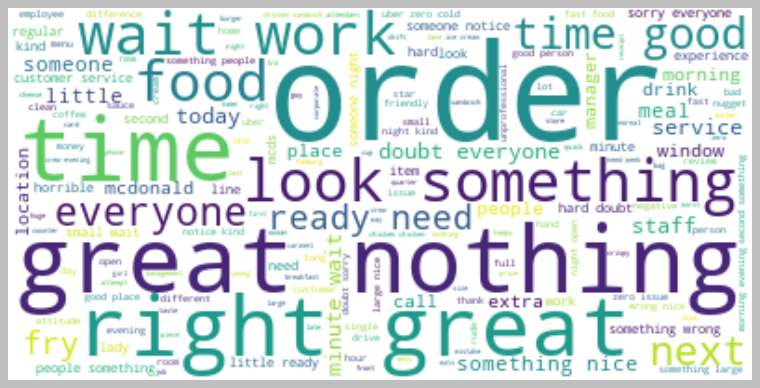

In [33]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

text = ""
topic_lda = df_st['topic_lda'].values
sub_aspect = df_st['sub_aspect'].values
for i in range(df_st.shape[0]):
    text = text + " " + " ".join(list(topic_lda[i])) + " " + " ".join(list(sub_aspect[i]))
    

text = text.strip()

wordcloud = WordCloud(background_color='white').generate(text)
plt.style.use('classic')
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [34]:
from scipy.spatial.distance import cosine

def get_aspect_topic(aspect, topic, model, threshold=0.5):
    max_value, max_key = 0, None
    for e in topic:
#         temp = get_min_word(aspect, e, model, get_all=True)
        temp = ensemble_min_word(aspect, e, all_models)
        if not temp:
            continue
        max_temp = list(temp.items())[0]
        if max_value < max_temp[1]:
            max_value = max_temp[1]
            max_key = max_temp[0]
    
    print(f"{max_key}: {max_value}")
    if max_value < threshold:
        return None
    return max_key

In [35]:
get_aspect_topic(aspects, 'everyone', model)

CHECK ('color', 0.2849656641483307)
CHECK ('color', 0.05506463348865509)
CHECK ('size', 0.050535742193460464)
CHECK ('color', 0.23297226428985596)
CHECK ('size', 0.04371265321969986)
CHECK ('color', 0.09182476997375488)
CHECK ('color', 0.2849656641483307)
CHECK ('color', 0.05506463348865509)
CHECK ('size', 0.050535742193460464)
CHECK ('size', 0.2156495749950409)
CHECK ('size', 0.09818705916404724)
CHECK ('color', 0.07851802557706833)
CHECK ('color', 0.2664864957332611)
CHECK ('color', 0.07136008888483047)
CHECK ('color', 0.14261314272880554)
CHECK ('size', 0.2325756698846817)
CHECK ('color', 0.10798586905002594)
CHECK ('color', 0.11808469146490097)
CHECK ('size', 0.3688446283340454)
CHECK ('size', 0.09513604640960693)
CHECK ('color', 0.09517805278301239)
CHECK ('color', 0.2849656641483307)
CHECK ('color', 0.05506463348865509)
CHECK ('size', 0.050535742193460464)
size: 0.3688446283340454


In [36]:
def ensemble_nearest_word(base, word, models, get_all=False):
    result = {}
    for model in models:
        items = util.get_nearest_word(word, base, model, get_all=True)
        print("CHECK", items)
        if not items:
            return None
        key, value = list(items.items())[0]
        if key in result.keys():
            curr_count, curr_value = result[key]
            if curr_value < value:
                new_value = (curr_count + 1, value)
            else:
                new_value = (curr_count + 1, curr_value)
            
            result[key] = new_value
        else:
            result[key] = (1, value)
    
    result = sorted(result.items(),
                    key=lambda item: (-item[1][0],
                                      -item[1][1]))
    result = dict(result)
    if get_all:
        return result
    
    max_key, max_value = list(result.items())[0]
    
    return max_key

In [37]:
ensemble_nearest_word(aspects, 'normal transaction', all_models)

CHECK {'size': 0.5382322072982788, 'quality': 0.5337847471237183, 'color': 0.36821529269218445}
CHECK {'size': 0.27985134720802307, 'quality': 0.19835299253463745, 'color': 0.13041582703590393}
CHECK {'size': 0.1376403123140335, 'quality': 0.10477233678102493, 'color': 0.03448309004306793}


'size'

In [38]:
df_st.head(50)

,reviewer_id,review,token_sentence,token_clean,topic_lda,cat_topic_lda,sub_aspect
0,1,Why does it look like someone spit on my food?...,Why does it look like someone spit on my food,why do it look like someone spit on my food,"{little, money, need}",7,{someone spit}
0,1,Why does it look like someone spit on my food?...,I had a normal transaction,i have a normal transaction,"{doubt, sorry, everyone}",8,{normal transaction}
0,1,Why does it look like someone spit on my food?...,everyone was chill and polite,everyone be chill and polite,"{hard, doubt, everyone}",8,{everyone}
0,1,Why does it look like someone spit on my food?...,but now i dont want to eat this.,but now i dont want to eat this .,{},0,{}
0,1,Why does it look like someone spit on my food?...,Im trying not to think about what this milky w...,im try not to think about what this milky whit...,"{time, good, person}",1,{clear substance}
0,1,Why does it look like someone spit on my food?...,i d sure am not coming back.,i d sure be not come back .,{},0,{}
1,2,It'd McDonalds. It is what it is as far as the...,It would McDonalds.,it would mcdonalds .,{},0,{}
1,2,It'd McDonalds. It is what it is as far as the...,It is what it is as far as the food and atmosp...,it be what it be as far as the food and atmosp...,"{someone, kind, fast}",3,"{atmosphere, food}"
1,2,It'd McDonalds. It is what it is as far as the...,The staff here does make a difference.,the staff here do make a difference .,"{doubt, difference, everyone}",8,"{staff, difference}"
1,2,It'd McDonalds. It is what it is as far as the...,They are all friendly,they be all friendly,"{wait, work, friendly}",2,{}


In [39]:
# aspects = ['food', 'service', 'order' ,'place']
aspects = ['food', 'service', 'order' ,]
# aspects = ['service', 'order', 'place']

def fun1(x):
    temp = set()
    for e in x:
#         aspect = util.get_nearest_word(e, aspects, model)
        aspect = ensemble_nearest_word(aspects, e, all_models)
        if aspect:
            temp.add(aspect)
    temp = list(temp)
    return temp

def fun2(x):
#     result = util.get_nearest_word(" ".join(x), aspects, model)
#     print(util.get_nearest_word(" ".join(x), aspects, model, 0.45, get_all=True))
    result = get_aspect_topic(aspects, x, model)
    if not result:
        return []
    return [result]

tqdm.pandas()
# df_st['sub_aspect'].apply(fun)
# df_st['aspect'] = df_st['sub_aspect'].progress_apply(lambda x: list({util.get_aspect(e, aspects=aspects, model=model) 
#                                                                      for e in x}))
df_st['aspect'] = df_st['sub_aspect'].progress_apply(fun1)
# df_st['aspect'] = df_st['topic_lda'].progress_apply(fun2)
# df_st['aspect'] = [list(set(fun1(i) + fun2(j))) for i,j in zip(df_st.sub_aspect, df_st.topic_lda)]
df_st

  5%|████▍                                                                           | 30/546 [00:00<00:01, 292.01it/s]

CHECK {'order': 0.32384100556373596, 'food': 0.29789572954177856, 'service': 0.2657887935638428}
CHECK {'food': 0.23130962252616882, 'order': 0.1199665442109108, 'service': 0.07792798429727554}
CHECK {'food': 0.13232186436653137, 'order': 0.08214081078767776, 'service': 0.06956950575113297}
CHECK {'order': 0.5524408221244812, 'service': 0.5327370762825012, 'food': 0.39506110548973083}
CHECK {'order': 0.32569214701652527, 'service': 0.2845168709754944, 'food': 0.14369182288646698}
CHECK {'service': 0.221317857503891, 'order': 0.20698599517345428, 'food': 0.04546332731842995}
CHECK {'order': 0.4961599111557007, 'food': 0.46295544505119324, 'service': 0.41436824202537537}
CHECK {'food': 0.19248953461647034, 'service': 0.1490120142698288, 'order': 0.13428974151611328}
CHECK {'food': 0.16934338212013245, 'service': 0.09132780879735947, 'order': 0.08983240276575089}
CHECK {'order': 0.5084662437438965, 'food': 0.45111578702926636, 'service': 0.3410953879356384}
CHECK {'order': 0.2009817808866

CHECK {'service': 0.9040338397026062, 'order': 0.5830984115600586, 'food': 0.4917876422405243}
CHECK {'service': 0.8932532072067261, 'order': 0.3117600977420807, 'food': 0.2906327247619629}
CHECK {'service': 0.813677966594696, 'order': 0.1873496025800705, 'food': 0.18604198098182678}
CHECK {'service': 0.49384593963623047, 'order': 0.47398245334625244, 'food': 0.34797540307044983}
CHECK {'service': 0.29739755392074585, 'order': 0.19431839883327484, 'food': 0.1907348930835724}
CHECK {'service': 0.24666975438594818, 'food': 0.12933756411075592, 'order': 0.05593208223581314}
CHECK {'order': 0.8844780325889587, 'service': 0.5633494853973389, 'food': 0.5272871255874634}
CHECK {'order': 0.7997928261756897, 'service': 0.2705387771129608, 'food': 0.19968116283416748}
CHECK {'order': 0.6972733736038208, 'service': 0.14739757776260376, 'food': 0.130353644490242}
CHECK {'service': 0.4871385395526886, 'order': 0.3893813490867615, 'food': 0.2975936830043793}
CHECK {'food': 0.24405638873577118, 'serv

 12%|█████████▌                                                                      | 65/546 [00:00<00:01, 311.01it/s]

CHECK {'food': 0.29410287737846375, 'order': 0.06867378950119019, 'service': 0.06798339635133743}
CHECK {'food': 0, 'service': 0, 'order': 0}
CHECK {'service': 0.6391804218292236, 'order': 0.49144890904426575, 'food': 0.41877663135528564}
CHECK {'service': 0.4108898639678955, 'food': 0.22138839960098267, 'order': 0.12345870584249496}
CHECK {'service': 0.28317034244537354, 'food': 0.12199943512678146, 'order': 0.0926898941397667}
CHECK {'order': 1, 'service': 0.5954257249832153, 'food': 0.4973985254764557}
CHECK {'order': 1, 'service': 0.2689184546470642, 'food': 0.19198539853096008}
CHECK {'order': 1, 'service': 0.14488232135772705, 'food': 0.12748083472251892}
CHECK {'order': 0.5102398991584778, 'food': 0.44850629568099976, 'service': 0.4258817434310913}
CHECK {'food': 0.3396744430065155, 'order': 0.22938883304595947, 'service': 0.19708774983882904}
CHECK {'order': 0.12547504901885986, 'food': 0.04261580482125282, 'service': 0.04094548523426056}
CHECK {'food': 0.6452903747558594, 'ord

 18%|██████████████▏                                                                 | 97/546 [00:00<00:01, 309.76it/s]

CHECK {'food': 0.18153728544712067, 'service': 0.12438000738620758, 'order': 0.00949628185480833}
CHECK {'order': 1, 'service': 0.5954257249832153, 'food': 0.4973985254764557}
CHECK {'order': 1, 'service': 0.2689184546470642, 'food': 0.19198539853096008}
CHECK {'order': 1, 'service': 0.14488232135772705, 'food': 0.12748083472251892}
CHECK {'order': 0.650295078754425, 'service': 0.5685608386993408, 'food': 0.43767860531806946}
CHECK {'order': 0.29358938336372375, 'service': 0.2506800889968872, 'food': 0.15430991351604462}
CHECK {'order': 0.16543316841125488, 'service': 0.13525409996509552, 'food': 0.06591792404651642}
CHECK {'order': 0.5970723628997803, 'service': 0.5846442580223083, 'food': 0.5034978985786438}
CHECK {'service': 0.2106664478778839, 'order': 0.1997344046831131, 'food': 0.07823150604963303}
CHECK {'service': 0.19011186063289642, 'order': 0.12533457577228546, 'food': 0.023595290258526802}
CHECK {'food': 0.42854002118110657, 'service': 0.38491982221603394, 'order': 0.357471

 23%|██████████████████▌                                                            | 128/546 [00:00<00:01, 299.27it/s]

CHECK {'order': 0.5842796564102173, 'service': 0.5657038688659668, 'food': 0.5073754787445068}
CHECK {'order': 0.26047635078430176, 'service': 0.2522701025009155, 'food': 0.19374194741249084}
CHECK {'food': 0.15051546692848206, 'order': 0.148256316781044, 'service': 0.12322654575109482}
CHECK {'food': 0.4326978623867035, 'order': 0.2531737983226776, 'service': 0.13639555871486664}
CHECK {'food': 0.25164201855659485, 'order': 0.09788016974925995, 'service': 0.05761873722076416}
CHECK {'food': 0.24560435116291046, 'order': 0.12183266133069992}
CHECK {'food': 0.8871968388557434, 'order': 0.841557502746582, 'service': 0.594642162322998}
CHECK {'food': 0.8873676061630249, 'order': 0.6228474378585815, 'service': 0.3708968758583069}
CHECK {'food': 0.819244921207428, 'order': 0.6732029914855957, 'service': 0.20957954227924347}
CHECK {'food': 0.8850268721580505, 'order': 0.42643314599990845, 'service': 0.37504905462265015}
CHECK {'food': 0.8900033831596375, 'service': 0.2904321849346161, 'order

CHECK {'order': 0.5949246883392334, 'service': 0.44470125436782837, 'food': 0.3278837203979492}
CHECK {'order': 0.2077634632587433, 'service': 0.19671374559402466, 'food': 0.09095795452594757}
CHECK {'service': 0.04929669201374054, 'order': 0.0412970632314682, 'food': 0.04077983647584915}
CHECK {'order': 0.5687785148620605, 'service': 0.49697554111480713, 'food': 0.3603626787662506}
CHECK {'order': 0.25267088413238525, 'service': 0.24316401779651642, 'food': 0.06268953531980515}
CHECK {'order': 0.14591124653816223, 'service': 0.09128616005182266, 'food': 0.002228599274531007}
CHECK {'service': 0.5340484976768494, 'order': 0.5019909739494324, 'food': 0.37620875239372253}
CHECK {'service': 0.24328148365020752, 'order': 0.2136385589838028, 'food': 0.1849593222141266}
CHECK {'service': 0.15163856744766235, 'food': 0.14253701269626617, 'order': 0.10729476064443588}
CHECK {'service': 0.4866047203540802, 'order': 0.4541204869747162, 'food': 0.27384263277053833}
CHECK {'order': 0.1873085349798

CHECK {'food': 0.46223869919776917, 'order': 0.41876518726348877, 'service': 0.3863947093486786}
CHECK {'food': 0.1553596705198288, 'order': 0.062293607741594315, 'service': 0.05867420509457588}


 33%|█████████████████████████▊                                                     | 178/546 [00:00<00:01, 362.43it/s]

CHECK {'food': 0.1179257184267044, 'service': 0.04450064152479172, 'order': 0.03573831915855408}
CHECK {'food': 0.40980908274650574, 'order': 0.3890906870365143, 'service': 0.3085285425186157}
CHECK {'food': 0.2592201232910156, 'service': 0.10436661541461945, 'order': 0.08291851729154587}
CHECK {'order': 0.11789119243621826, 'food': 0.09693139791488647, 'service': 0.051782019436359406}
CHECK {'food': 0.3356832265853882, 'order': 0.31838950514793396, 'service': 0.2526455819606781}
CHECK {'food': 0.19466114044189453, 'order': 0.09349778294563293, 'service': 0.08543664216995239}
CHECK {'order': 0.09645406156778336, 'food': 0.08668789267539978, 'service': 0.052175529301166534}
CHECK {'order': 0.6397656202316284, 'service': 0.5943596363067627, 'food': 0.4306838810443878}
CHECK {'order': 0.29988932609558105, 'service': 0.29837092757225037, 'food': 0.012083174660801888}
CHECK {'order': 0.19940268993377686, 'service': 0.1893118917942047, 'food': 0.019456634297966957}
CHECK {'order': 0.61440449

 39%|███████████████████████████████                                                | 215/546 [00:00<00:00, 342.51it/s]

CHECK {'order': 0.1734616756439209, 'service': 0.1444917619228363, 'food': 0.07930517941713333}
CHECK {'order': 0.38742053508758545, 'service': 0.37417927384376526, 'food': 0.25400081276893616}
CHECK {'order': 0.16520190238952637, 'service': 0.15345092117786407, 'food': 0.021862246096134186}
CHECK {'order': 0.12771300971508026, 'service': 0.04533860832452774, 'food': 0.034019969403743744}
CHECK {'order': 0.5197688937187195, 'service': 0.3986676335334778, 'food': 0.3788224458694458}
CHECK {'order': 0.13120785355567932, 'service': 0.12730298936367035, 'food': 0.10276446491479874}
CHECK {'food': 0.1068255752325058, 'order': 0.09791206568479538, 'service': 0.09471485763788223}
CHECK {'service': 0.5425755977630615, 'order': 0.4665077030658722, 'food': 0.344178169965744}
CHECK {'service': 0.2555030286312103, 'food': 0.19434116780757904, 'order': 0.18166238069534302}
CHECK {'service': 0.1868075132369995, 'food': 0.12358802556991577, 'order': 0.11047438532114029}
CHECK {'order': 0.644414663314

 46%|████████████████████████████████████▏                                          | 250/546 [00:00<00:00, 299.20it/s]

 {'order': 0.024026881903409958}
CHECK {'order': 0.6058721542358398, 'service': 0.5671968460083008, 'food': 0.31505945324897766}
CHECK {'order': 0.17571868002414703, 'service': 0.17077811062335968, 'food': 0.08395402133464813}
CHECK {'order': 0.16785012185573578, 'food': 0.07019442319869995, 'service': 0.05463375523686409}
CHECK {'service': 0.6391804218292236, 'order': 0.49144890904426575, 'food': 0.41877663135528564}
CHECK {'service': 0.4108898639678955, 'food': 0.22138839960098267, 'order': 0.12345870584249496}
CHECK {'service': 0.28317034244537354, 'food': 0.12199943512678146, 'order': 0.0926898941397667}
CHECK {'service': 0.5491877794265747, 'order': 0.5176033973693848, 'food': 0.4595976769924164}
CHECK {'service': 0.3123353123664856, 'order': 0.21100987493991852, 'food': 0.16842955350875854}
CHECK {'service': 0.22996017336845398, 'food': 0.1422608643770218, 'order': 0.1081380620598793}
CHECK {'service': 0.8346598148345947, 'order': 0.5274465084075928, 'food': 0.38228875398635864}


 52%|████████████████████████████████████████▊                                      | 282/546 [00:00<00:00, 292.34it/s]

CHECK {'service': 0.3895237147808075, 'order': 0.34245118498802185, 'food': 0.2906267046928406}
CHECK {'service': 0.19684697687625885, 'food': 0.10103640705347061, 'order': 0.0859839916229248}
CHECK {'service': 0.09006460756063461, 'food': 0.04504192993044853, 'order': 0.0433211624622345}
CHECK {'order': 0.43953388929367065, 'service': 0.3623693287372589, 'food': 0.3380867838859558}
CHECK {'service': 0.12702569365501404, 'food': 0.10697506368160248, 'order': 0.07572954893112183}
CHECK {'order': 0.07986749708652496, 'service': 0.058029212057590485, 'food': 0.020336292684078217}
CHECK {'order': 0.47303226590156555, 'food': 0.34705275297164917, 'service': 0.3099013864994049}
CHECK {'order': 0.12527208030223846, 'food': 0.07580859959125519, 'service': 0.04735761135816574}
CHECK {'order': 0.07781662046909332, 'food': 0.05648064613342285, 'service': 0.04586803540587425}
CHECK {'order': 0.5971112251281738, 'service': 0.5020469427108765, 'food': 0.450165718793869}
CHECK {'service': 0.200476154

CHECK {'food': 0.4812943637371063, 'service': 0.2653217017650604, 'order': 0.2545439600944519}
CHECK {'food': 0.318680077791214, 'order': 0.10857313126325607, 'service': 0.1004946231842041}
CHECK {'food': 0.1661069691181183, 'order': 0.1139015257358551, 'service': 0.05379260331392288}
CHECK {'service': 0.4549856185913086, 'food': 0.3874947130680084, 'order': 0.3098624050617218}
CHECK {'service': 0.34010010957717896, 'food': 0.18674665689468384, 'order': 0.17866410315036774}
CHECK {'service': 0.3627699315547943, 'food': 0.1783149540424347, 'order': 0.10689352452754974}
CHECK {'service': 0.9040338397026062, 'order': 0.5830984115600586, 'food': 0.4917876422405243}
CHECK {'service': 0.8932532072067261, 'order': 0.3117600977420807, 'food': 0.2906327247619629}
CHECK {'service': 0.813677966594696, 'order': 0.1873496025800705, 'food': 0.18604198098182678}
CHECK {'order': 0.23144343495368958, 'service': 0.14051876962184906, 'food': 0.09119462221860886}
CHECK {'service': 0.24727405607700348, 'fo

 60%|███████████████████████████████████████████████                                | 325/546 [00:01<00:00, 264.93it/s]

CHECK {'service': 0.2226324826478958, 'food': 0.16948352754116058, 'order': 0.1309131383895874}
CHECK {'service': 0.1495591402053833, 'food': 0.06974943727254868, 'order': 0.008304253220558167}
CHECK {'service': 0.44671565294265747, 'order': 0.2983717918395996, 'food': 0.2736683785915375}
CHECK {'service': 0.26912644505500793, 'food': 0.11063843965530396, 'order': 0.09314128756523132}
CHECK {'service': 0.09355789422988892, 'food': 0.021046537905931473, 'order': 0.004070426803082228}
CHECK {'service': 0.4088969826698303, 'order': 0.3852788209915161, 'food': 0.3687942922115326}
CHECK {'order': 0.0957803875207901, 'service': 0.09022911638021469, 'food': 0.06995142251253128}
CHECK {'service': 0.09441880881786346, 'food': 0.08953388035297394, 'order': 0.018355950713157654}
CHECK {'service': 0.25775840878486633, 'food': 0.10683643817901611, 'order': 0.07636929303407669}
CHECK {'service': 0.07348554581403732, 'food': 0.02049299329519272, 'order': 0.014585033059120178}
CHECK {'service': 0.1141

 65%|███████████████████████████████████████████████████▌                           | 356/546 [00:01<00:00, 272.43it/s]

CHECK {'order': 0.17268259823322296, 'service': 0.12616850435733795, 'food': 0.11796757578849792}
CHECK {'food': 0.13002565503120422, 'service': 0.1206798329949379, 'order': 0.08111537992954254}
CHECK {'food': 0.06733623892068863, 'service': 0.06630665063858032, 'order': 0.036070700734853745}
CHECK {'service': 0.511934220790863, 'order': 0.46867620944976807, 'food': 0.309430330991745}
CHECK {'service': 0.24924932420253754, 'food': 0.2017941176891327, 'order': 0.12399081885814667}
CHECK {'service': 0.09807561337947845, 'food': 0.06274200975894928, 'order': 0.03206011280417442}
CHECK {'food': 0.28165939450263977, 'order': 0.262611448764801, 'service': 0.17467479407787323}
CHECK {'food': 0.19880717992782593, 'service': 0.10795692354440689, 'order': 0.06885456293821335}
CHECK {'service': 0.11997756361961365, 'food': 0.10748203098773956, 'order': 0.06713854521512985}
CHECK {'order': 0.6058721542358398, 'service': 0.5671968460083008, 'food': 0.31505945324897766}
CHECK {'order': 0.17571868002

CHECK {'service': 0.10513952374458313}


 84%|██████████████████████████████████████████████████████████████████▍            | 459/546 [00:01<00:00, 380.29it/s]

CHECK {'food': 0.2287227064371109, 'service': 0.08532674610614777, 'order': 0.05946474149823189}
CHECK {'food': 0.21084627509117126, 'service': 0.1126331239938736, 'order': 0.061158616095781326}
CHECK {'food': 0.16882586479187012, 'service': 0.11355972290039062, 'order': 0.08024752140045166}
CHECK {'food': 0.2929385006427765, 'service': 0.04776914417743683}
CHECK {'food': 0.35317179560661316, 'service': 0.186951145529747, 'order': 0.1602354347705841}
CHECK {'food': 0.24897877871990204, 'service': 0.19253773987293243, 'order': 0.09375875443220139}
CHECK {'order': 0.5848353505134583, 'food': 0.45284152030944824, 'service': 0.44648492336273193}
CHECK {'order': 0.21421509981155396, 'service': 0.1500225067138672, 'food': 0.06931862980127335}
CHECK {'order': 0.10853145271539688, 'food': 0.09289585053920746, 'service': 0.02342531830072403}
CHECK {'service': 0.5834978818893433, 'order': 0.39915627241134644, 'food': 0.3194696605205536}
CHECK {'service': 0.3063988983631134, 'order': 0.1670137196

CHECK {'order': 0.17011773586273193, 'service': 0.14585554599761963, 'food': 0.08441058546304703}
CHECK {'order': 0.6481515765190125, 'service': 0.5995334982872009, 'food': 0.5237342715263367}
CHECK {'order': 0.2882848083972931, 'service': 0.1669394075870514, 'food': 0.1484331637620926}
CHECK {'order': 0.17018765211105347, 'food': 0.13398219645023346, 'service': 0.1329665631055832}


100%|███████████████████████████████████████████████████████████████████████████████| 546/546 [00:01<00:00, 347.89it/s]

CHECK {'order': 0.6274182796478271, 'food': 0.5439335107803345, 'service': 0.5076813697814941}
CHECK {'food': 0.19608300924301147, 'order': 0.19045908749103546, 'service': 0.1548556685447693}
CHECK {'service': 0.14472641050815582, 'food': 0.1358301192522049, 'order': 0.07283442467451096}
CHECK {'order': 0.4004526734352112, 'service': 0.36578693985939026, 'food': 0.349067747592926}
CHECK {'food': 0.12586191296577454, 'service': 0.0887579396367073, 'order': 0.050356581807136536}
CHECK {'food': 0.09206604957580566, 'service': 0.06876024603843689, 'order': 0.030442437157034874}
CHECK {'food': 0.6538514494895935, 'order': 0.5071325898170471, 'service': 0.4701036214828491}
CHECK {'food': 0.3538172245025635, 'service': 0.1590520143508911, 'order': 0.13503363728523254}
CHECK {'food': 0.3257763683795929, 'order': 0.1597752869129181, 'service': 0.08674577623605728}
CHECK {'food': 0.6897025108337402, 'order': 0.48468026518821716, 'service': 0.4371650516986847}
CHECK {'food': 0.3663279712200165, '

,reviewer_id,review,token_sentence,token_clean,topic_lda,cat_topic_lda,sub_aspect,aspect
0,1,Why does it look like someone spit on my food?...,Why does it look like someone spit on my food,why do it look like someone spit on my food,"{little, money, need}",7,{someone spit},[food]
0,1,Why does it look like someone spit on my food?...,I had a normal transaction,i have a normal transaction,"{doubt, sorry, everyone}",8,{normal transaction},[order]
0,1,Why does it look like someone spit on my food?...,everyone was chill and polite,everyone be chill and polite,"{hard, doubt, everyone}",8,{everyone},[food]
0,1,Why does it look like someone spit on my food?...,but now i dont want to eat this.,but now i dont want to eat this .,{},0,{},[]
0,1,Why does it look like someone spit on my food?...,Im trying not to think about what this milky w...,im try not to think about what this milky whit...,"{time, good, person}",1,{clear substance},[order]
...,...,...,...,...,...,...,...,...
98,99,Allways has the best Fries and Ice cream in th...,Allways has the best Fries and Ice cream in th...,allways have the best fry and ice cream in the...,"{night, cream, sauce}",3,"{ice cream, best fry, allways}","[food, service]"
99,100,Mcdonalds is great but they really need to hir...,Mcdonalds is great,mcdonalds be great,"{great, nothing, mcdonalds}",4,{mcdonalds},[food]
99,100,Mcdonalds is great but they really need to hir...,they really need to hire people who understand...,they really need to hire people who understand...,{},0,"{order, people, english order, spanish speaker}","[order, food]"
99,100,Mcdonalds is great but they really need to hir...,The people are really nice,the people be really nice,"{people, something, nice}",6,{people},[food]


In [40]:
df_st['aspect'].value_counts()

[]                        142
[order]                   107
[food]                    103
[service]                  72
[order, food]              43
[order, service]           39
[food, service]            23
[order, food, service]     17
Name: aspect, dtype: int64

In [41]:
df_st['sub_aspect'].value_counts()

{}                                                                     140
{order}                                                                 13
{location}                                                               4
{food}                                                                   4
{line}                                                                   4
                                                                      ... 
{pinballz arcade, line, nothing, parking lot, multiple time}             1
{people, dinner food, order, parking lot, minute}                        1
{caramel mocha, room temperature, minute wait, temperature caramel}      1
{sarcasm}                                                                1
{people}                                                                 1
Name: sub_aspect, Length: 367, dtype: int64

# Sentiment Analysis

In [42]:
import util.model as models

In [43]:
sample = df_st['token_clean'].iloc[4]
print(sample)
models.pattern_lexicon_model(sample)

im try not to think about what this milky white or clear substance be all over my food


'negative'

In [44]:
tqdm.pandas()
df_st['pattern_prediction'] = df_st['token_clean'].progress_apply(models.pattern_lexicon_model)

100%|██████████████████████████████████████████████████████████████████████████████| 546/546 [00:00<00:00, 5849.78it/s]


In [45]:
tqdm.pandas()
df_st['roberta_prediction'] = df_st['token_sentence'].progress_apply(models.roberta_model)

100%|████████████████████████████████████████████████████████████████████████████████| 546/546 [09:45<00:00,  1.07s/it]


# Get Result

In [46]:
def get_result(aspect, model):
    
    # Initialization
    get_aspects = df_st['aspect'].values
    get_predictions = df_st[model].values
    
    temp = []

    for i in range(len(get_aspects)):
        if (not get_aspects[i]) or (aspect not in get_aspects[i]):
            temp.append(0)
        else:
            if get_predictions[i] == 'negative':
                temp.append(-99)
            else:
                temp.append(1)
    return np.array(temp)

In [47]:
get_aspects = df_st['aspect'].values
get_pattern = df_st['pattern_prediction'].values
get_roberta = df_st['roberta_prediction'].values

new_fields = set()
for aspect in aspects:
    
    df_st[aspect + f"_pattern"] = get_result(aspect, 'pattern_prediction')
    df_st[aspect + f"_roberta"] = get_result(aspect, 'roberta_prediction')
    new_fields.add(aspect + f"_pattern")
    new_fields.add(aspect + f"_roberta")
new_fields = list(new_fields)
print(df_st.info())
df_st

<class 'pandas.core.frame.DataFrame'>
Int64Index: 546 entries, 0 to 99
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   reviewer_id         546 non-null    int64 
 1   review              546 non-null    object
 2   token_sentence      546 non-null    object
 3   token_clean         546 non-null    object
 4   topic_lda           546 non-null    object
 5   cat_topic_lda       546 non-null    int64 
 6   sub_aspect          546 non-null    object
 7   aspect              546 non-null    object
 8   pattern_prediction  546 non-null    object
 9   roberta_prediction  546 non-null    object
 10  food_pattern        546 non-null    int32 
 11  food_roberta        546 non-null    int32 
 12  service_pattern     546 non-null    int32 
 13  service_roberta     546 non-null    int32 
 14  order_pattern       546 non-null    int32 
 15  order_roberta       546 non-null    int32 
dtypes: int32(6), int64(2), obje

,reviewer_id,review,token_sentence,token_clean,topic_lda,cat_topic_lda,sub_aspect,aspect,pattern_prediction,roberta_prediction,food_pattern,food_roberta,service_pattern,service_roberta,order_pattern,order_roberta
0,1,Why does it look like someone spit on my food?...,Why does it look like someone spit on my food,why do it look like someone spit on my food,"{little, money, need}",7,{someone spit},[food],negative,negative,-99,-99,0,0,0,0
0,1,Why does it look like someone spit on my food?...,I had a normal transaction,i have a normal transaction,"{doubt, sorry, everyone}",8,{normal transaction},[order],positive,positive,0,0,0,0,1,1
0,1,Why does it look like someone spit on my food?...,everyone was chill and polite,everyone be chill and polite,"{hard, doubt, everyone}",8,{everyone},[food],negative,positive,-99,1,0,0,0,0
0,1,Why does it look like someone spit on my food?...,but now i dont want to eat this.,but now i dont want to eat this .,{},0,{},[],negative,negative,0,0,0,0,0,0
0,1,Why does it look like someone spit on my food?...,Im trying not to think about what this milky w...,im try not to think about what this milky whit...,"{time, good, person}",1,{clear substance},[order],negative,positive,0,0,0,0,-99,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98,99,Allways has the best Fries and Ice cream in th...,Allways has the best Fries and Ice cream in th...,allways have the best fry and ice cream in the...,"{night, cream, sauce}",3,"{ice cream, best fry, allways}","[food, service]",positive,positive,1,1,1,1,0,0
99,100,Mcdonalds is great but they really need to hir...,Mcdonalds is great,mcdonalds be great,"{great, nothing, mcdonalds}",4,{mcdonalds},[food],positive,positive,1,1,0,0,0,0
99,100,Mcdonalds is great but they really need to hir...,they really need to hire people who understand...,they really need to hire people who understand...,{},0,"{order, people, english order, spanish speaker}","[order, food]",negative,positive,-99,1,0,0,-99,1
99,100,Mcdonalds is great but they really need to hir...,The people are really nice,the people be really nice,"{people, something, nice}",6,{people},[food],positive,positive,1,1,0,0,0,0


In [48]:
grouped_df = df_st[ ['reviewer_id'] + new_fields ].groupby('reviewer_id').sum()

grouped_df = grouped_df.applymap(lambda x: 0 if x < 0 else 1).reset_index()

grouped_df

,reviewer_id,food_roberta,food_pattern,order_roberta,service_pattern,service_roberta,order_pattern
0,1,0,0,1,1,1,0
1,2,1,1,1,0,1,0
2,3,0,0,1,0,0,0
3,4,1,0,1,0,1,1
4,5,1,1,0,1,1,0
...,...,...,...,...,...,...,...
95,96,1,0,0,0,0,0
96,97,0,0,1,0,0,1
97,98,1,1,0,0,0,0
98,99,1,1,1,1,1,1


In [49]:
result = df.merge(grouped_df, on='reviewer_id', how='left')

print(result.info())
result.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100 entries, 0 to 99
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   reviewer_id      100 non-null    int64 
 1   review_time      100 non-null    object
 2   review           100 non-null    object
 3   rating           100 non-null    object
 4   food_roberta     100 non-null    int64 
 5   food_pattern     100 non-null    int64 
 6   order_roberta    100 non-null    int64 
 7   service_pattern  100 non-null    int64 
 8   service_roberta  100 non-null    int64 
 9   order_pattern    100 non-null    int64 
dtypes: int64(7), object(3)
memory usage: 8.6+ KB
None


,reviewer_id,review_time,review,rating,food_roberta,food_pattern,order_roberta,service_pattern,service_roberta,order_pattern
0,1,3 months ago,Why does it look like someone spit on my food?...,1 star,0,0,1,1,1,0
1,2,5 days ago,It'd McDonalds. It is what it is as far as the...,4 stars,1,1,1,0,1,0
2,3,5 days ago,Made a mobile order got to the speaker and che...,1 star,0,0,1,0,0,0
3,4,a month ago,My mc. Crispy chicken sandwich was ï¿½ï¿½ï¿½ï¿...,5 stars,1,0,1,0,1,1
4,5,2 months ago,"I repeat my order 3 times in the drive thru, a...",1 star,1,1,0,1,1,0


# Evaluation

In [50]:
df_val = pd.read_csv('validation.csv').dropna()

print(df_val.info())
df_val.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100 entries, 0 to 99
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   reviewer_id  100 non-null    int64 
 1   review_time  100 non-null    object
 2   review       100 non-null    object
 3   rating       100 non-null    object
 4   food         100 non-null    object
 5   service      100 non-null    object
 6   order        100 non-null    object
 7   place        100 non-null    object
dtypes: int64(1), object(7)
memory usage: 7.0+ KB
None


,reviewer_id,review_time,review,rating,food,service,order,place
0,1,3 months ago,Why does it look like someone spit on my food?...,1 star,Negative,Neutral,Positive,Neutral
1,2,5 days ago,It'd McDonalds. It is what it is as far as the...,4 stars,Neutral,Positive,Neutral,Positive
2,3,5 days ago,Made a mobile order got to the speaker and che...,1 star,Neutral,Negative,Negative,Neutral
3,4,a month ago,My mc. Crispy chicken sandwich was ï¿½ï¿½ï¿½ï¿...,5 stars,Positive,Positive,Neutral,Neutral
4,5,2 months ago,"I repeat my order 3 times in the drive thru, a...",1 star,Negative,Negative,Negative,Neutral


In [51]:
def mapping_sentiment(x):
    if x == 'Negative':
        return 0
    else:
        return 1    

def join_aspect(x, y):
    if x==1 and y==1:
        return 1
    else:
        return 0
    
for aspect in ['food', 'service', 'order', 'place']:
    df_val[aspect] = df_val[aspect].apply(mapping_sentiment)

# df_val['service'] = [join_aspect(x, y) for x, y in zip(df_val.service, df_val.order)]
# df_val = df_val.drop('order', axis=1)
print(df_val.info())
df_val.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100 entries, 0 to 99
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   reviewer_id  100 non-null    int64 
 1   review_time  100 non-null    object
 2   review       100 non-null    object
 3   rating       100 non-null    object
 4   food         100 non-null    int64 
 5   service      100 non-null    int64 
 6   order        100 non-null    int64 
 7   place        100 non-null    int64 
dtypes: int64(5), object(3)
memory usage: 7.0+ KB
None


,reviewer_id,review_time,review,rating,food,service,order,place
0,1,3 months ago,Why does it look like someone spit on my food?...,1 star,0,1,1,1
1,2,5 days ago,It'd McDonalds. It is what it is as far as the...,4 stars,1,1,1,1
2,3,5 days ago,Made a mobile order got to the speaker and che...,1 star,1,0,0,1
3,4,a month ago,My mc. Crispy chicken sandwich was ï¿½ï¿½ï¿½ï¿...,5 stars,1,1,1,1
4,5,2 months ago,"I repeat my order 3 times in the drive thru, a...",1 star,0,0,0,1


In [52]:
from sklearn.metrics import classification_report, roc_auc_score

print("Prediction pattern")
print("==============================================================")
for aspect in aspects:
    try:
        actual = df_val[aspect]
        pred = result[aspect + "_pattern"]
        print(f"ROC AUC Score: ", roc_auc_score(actual, pred))
        print(f"Result {aspect}")
        print(classification_report(actual, pred))
    except:
        continue

Prediction pattern
ROC AUC Score:  0.652875175315568
Result food
              precision    recall  f1-score   support

           0       0.41      0.87      0.56        31
           1       0.88      0.43      0.58        69

    accuracy                           0.57       100
   macro avg       0.65      0.65      0.57       100
weighted avg       0.74      0.57      0.57       100

ROC AUC Score:  0.6175824175824175
Result service
              precision    recall  f1-score   support

           0       0.74      0.69      0.71        65
           1       0.49      0.54      0.51        35

    accuracy                           0.64       100
   macro avg       0.61      0.62      0.61       100
weighted avg       0.65      0.64      0.64       100

ROC AUC Score:  0.6621787025703795
Result order
              precision    recall  f1-score   support

           0       0.69      0.79      0.74        57
           1       0.66      0.53      0.59        43

    accuracy       

In [53]:
print("Prediction roberta")
print("==============================================================")
for aspect in aspects:
    try:
        actual = df_val[aspect]
        pred = result[aspect + "_roberta"]
        print(f"ROC AUC Score: ", roc_auc_score(actual, pred))
        print(f"Result {aspect}")
        print(classification_report(actual, pred))
    except:
        continue

Prediction roberta
ROC AUC Score:  0.698690977092099
Result food
              precision    recall  f1-score   support

           0       0.48      0.77      0.59        31
           1       0.86      0.62      0.72        69

    accuracy                           0.67       100
   macro avg       0.67      0.70      0.66       100
weighted avg       0.74      0.67      0.68       100

ROC AUC Score:  0.7659340659340659
Result service
              precision    recall  f1-score   support

           0       0.91      0.65      0.76        65
           1       0.57      0.89      0.70        35

    accuracy                           0.73       100
   macro avg       0.74      0.77      0.73       100
weighted avg       0.79      0.73      0.74       100

ROC AUC Score:  0.7609139126886986
Result order
              precision    recall  f1-score   support

           0       0.81      0.75      0.78        57
           1       0.70      0.77      0.73        43

    accuracy       